## i. O DESAFIO

*   De posse de um dataset contendo informações sobre diversos modelos de carros com seus respectivos preços de venda, tomou-se a decisão de aplicar um modelo de machine learning capaz de realizar a **previsão** de preço de novas entradas na base de dados.

*   After collecting data from their clients database during the period of 1 year, the company's marketing team is analyzing wheter it would be profitable or not to separate it into distinct groups, in order to distinguish those who represent a larger ammount of the company's earnings.

*   De posse da solução, times de negócio podem simular com maior clareza quais os fatores que mais influenciam no preço de venda, tomando vantagem nos negócios a partir de soluções adotadas a partir de dados (Data Driven)

## ii. QUESTÕES DE NEGÓCIO

*   Ao término da aplicação do modelo, é esperado um relatório contendo respostas e curso de ação para as seguintes perguntas:

    1.  Quais as características(features) que mais influenciam a alteração do preço do veículo ?
    
    2.  Quais as premissas tomadas ao longo do processo de tratamento, análise de dados e feature engineering?

    3.  Qual a performance do modelo aplicado e como expressar-los à times de negócio?

    4.  Como colocar o modelo em produção?
    
    5.  Quais são possíveis rotas para a melhoria contínua do modelo?



# 0.0 IMPORTS, FUNCTIONS AND DATABASE LOAD

## 0.1 Imports

In [1]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import ipywidgets
import inflection
import optuna
import warnings
import os

from matplotlib         import pyplot as plt
from collections        import Counter
from ydata_profiling    import ProfileReport
from pandasql           import sqldf

from sklearn.preprocessing      import MinMaxScaler, StandardScaler
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.model_selection    import train_test_split, StratifiedKFold, KFold
from sklearn.metrics            import log_loss

from imblearn.ensemble          import BalancedRandomForestClassifier
from imblearn.pipeline          import Pipeline
from imblearn.combine           import SMOTEENN
from imblearn.under_sampling    import EditedNearestNeighbours

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Helper Functions

In [2]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Database load

In [9]:
df_alt = pd.read_csv('/home/valquiriaam/repos/PA005/datasets/code_challenge/car_prices.csv')
df_alt.sample(10)

year       make       model     trim       body transmission                vin state  condition  odometer   color interior                                seller      mmr  sellingprice                                 saledate
498572  2012      Dodge     Avenger      SXT      sedan    automatic  1c3cdzcb9cn219795    tx       43.0   41761.0     red    black                      chrysler capital   9600.0        9800.0  Tue Jun 02 2015 17:00:00 GMT-0700 (PDT)
546257  2010        Kia       Forte       EX      sedan    automatic  knafu4a23a5854777    ca       41.0   77806.0     red    beige                     desert auto trade   5775.0        6900.0  Tue Jun 16 2015 05:30:00 GMT-0700 (PDT)
135259  2010        GMC     Terrain    SLT-1        SUV          NaN  2ctalfew2a6289312    mi       44.0   94583.0    gray    black                          grace motors  10650.0       10400.0  Thu Jan 15 2015 01:30:00 GMT-0800 (PST)
145648  2006   Chrysler  PT Cruiser  Touring      Wagon    automatic  3a4fy58b46t222794    nc       31.0  126490.0  silver     gray                 dt credit corporation   1625.0        2400.0  Tue Jan 20 2015 01:30:00 GMT-0800 (PST)
364626  2014  Chevrolet       Cruze      2LT      Sedan    automatic  1g1pe5sbxe7363862    il        4.0   14628.0     red     gray                        gm remarketing  13550.0       14800.0  Thu Mar 05 2015 03:00:00 GMT-0800 (PST)
127093  2009   Infiniti         M35     Base      Sedan    automatic  jnkcy01e19m800620    ga       25.0   80413.0    gray    black        mercedes benz of south atlanta  13250.0       13800.0  Thu Jan 15 2015 02:00:00 GMT-0800 (PST)
63284   2012     Nissan      Altima    2.5 S      Sedan    automatic  1n4al2apxcn471119    fl        2.0   36708.0  silver     gray                    nissan-infiniti lt  12100.0       11200.0  Tue Jan 06 2015 01:30:00 GMT-0800 (PST)
314983  2013      Mazda      Mazda2  Touring  Hatchback    automatic  jm1de1ly8d0158442    tx       42.0   44286.0     red        —                      avis corporation   9150.0        9500.0  Wed Feb 18 2015 02:00:00 GMT-0800 (PST)
225736  2011      Mazda      Mazda3  s Sport      Sedan          NaN  jm1bl1u62b1381111    pa       41.0   34145.0    gray    black              jpmorgan chase bank n.a.  10600.0       10800.0  Fri Feb 06 2015 01:00:00 GMT-0800 (PST)
389760  2012      Honda     Odyssey       EX    Minivan          NaN  5fnrl5h43cb035883    pa       29.0   22918.0  silver     gray  ahfc/honda lease trust/hvt  inc. eot  19300.0       18400.0  Fri Mar 06 2015 01:00:00 GMT-0800 (PST)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

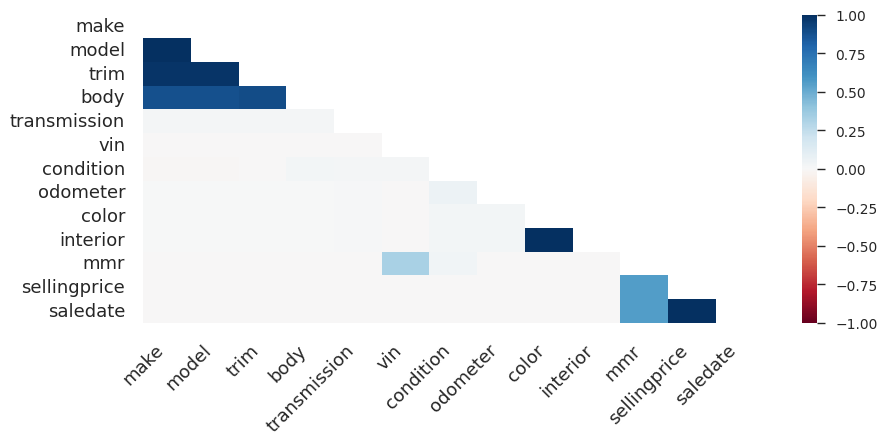

In [5]:
df_alt_profile = ProfileReport(df_alt, title='Alternate Report')
df_alt_profile

In [20]:
df_raw = pd.read_csv('/home/valquiriaam/repos/PA005/datasets/ecommerce.csv', encoding='unicode_escape')
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country  Unnamed: 8
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55     17850.0  United Kingdom         NaN
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39     17850.0  United Kingdom         NaN
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75     17850.0  United Kingdom         NaN
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39     17850.0  United Kingdom         NaN
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39     17850.0  United Kingdom         NaN

In [21]:

df1 = df_raw.copy()
df1 = df1.drop(columns=['Unnamed: 8'])

In [22]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 541909
Number of Columns: 8


# 1.0 DATA DESCRIPTION

### 1.3.1 General Description

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

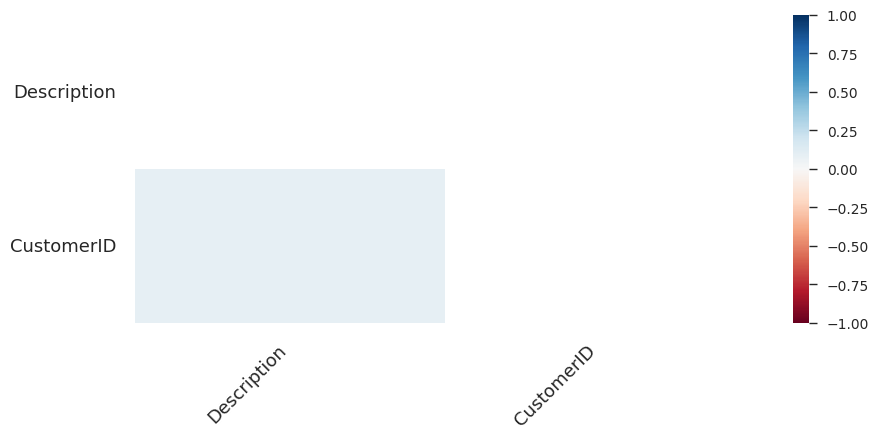

In [23]:
df1_profile = ProfileReport(df1, title='Profile Report')
df1_profile

### 1.3.2 Data Typification

*   InvoiceNo: Unique Transaction ID

*   StockCode: Item's ID code

*   Description: Item's name

*   Quantity: Quantity of product bought

*   InvoiceDate: Transaction's occurance date

*   UnitPrice:  Product's price per unit

*   CustomerID: Customer's ID code

*   Country: Customer's Country

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [25]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.3.3 Missing Data Treatment

In [26]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [27]:
df1[df1['unit_price'] <= -0.1]

invoice_no stock_code      description  quantity invoice_date  unit_price  customer_id         country
299983    A563186          B  Adjust bad debt         1    10-Aug-17   -11062.06          NaN  United Kingdom
299984    A563187          B  Adjust bad debt         1    10-Aug-17   -11062.06          NaN  United Kingdom

In [33]:
df1 = df1.dropna(subset=['customer_id'])
df1['customer_id'] = df1['customer_id'].astype(np.int64)

df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55        17850  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39        17850  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75        17850  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39        17850  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39        17850  United Kingdom

Upon Analyzing first Pandas profiling:

*   Customer_id entries with NaN values will be dropped (Not possible to identify the desired client)
*   Entry with 'unit_price' listed as a negative value (-11062,06) will be deleted. (Not a sale entry, it is descripted as a bad debt adjust)
*   Rows with quantity listed as negative values are always corrective entries from its previous ones, and its invoice_number always follows the pattern Cxxxxxx. Thus, every Cxxxxxx and its will be deleted in order to reduce noise on the dataset.

*** VERIFICAR ESTRATÉGIAS ADEQUADAS DE PREENCHIMENTO DE DADOS FALTANTES ***

## 1.4 Numerical Data Description

In [ ]:
# Data Selection
df1_num = df1.select_dtypes(include=['int64', 'float64'])

#Central Tendency
ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(df1_num.apply(min)).T
d2 = pd.DataFrame(df1_num.apply(max)).T
d3 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1_num.apply(np.std)).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

df_descript = pd.concat([d1, d2, d3, ct1, ct2, d4, d5, d6]).T
df_descript.columns = ['min','max', 'range', 'average', 'median', 'std', 'skew', 'kurtosis']
df_descript

*** ANOTAR OBSERVAÇÕES SOBRE AS DISTRIBUIÇÕES OBSERVADAS E POSSÍVEIS INSIGHTS ***

## 1.5 Categorical Data Description

*** ANOTAR OBSERVAÇÕES SOBRE AS DISTRIBUIÇÕES OBSERVADAS E POSSÍVEIS INSIGHTS ***

# 2.0 DATA PREPARATION

## 2.1 Hypothesis Creation

In [ ]:
df2 = df1.copy()

### 2.1.1 Hypothesis Mindmap

### 2.1.2 Created Hypothesis

## 2.2 EDA and Feature Engineering

### 2.2.1 Univariative Analysis

In [ ]:
df2_num = df2.select_dtypes(include=['int64', 'float64'])

df2_num.hist(bins=25);

*** Verificar comportamento das distribuições/outliers ***
*** Verificar Comportamento das variáveis categóricas ***

### 2.2.2 Bivariative Analysis

***Validação das Hipóteses/ Feature Engineering/ Mapa de Calor ***

## 2.3 Data Preparation

## 2.4 Feature Selection

# 3.0 MODELING

# 4.0 RESULTS VALIDATION

# 5.0 MODEL IMPLEMENTATION